# BAS RVG1 – Vergleich Whisper Large V3 vs. Parakeet TDT v3

Dieses Notebook lädt die aggregierten Ergebnisse aus `bas_rvg.csv` und vergleicht die Performance von zwei State-of-the-Art ASR-Modellen:
- **Whisper Large V3** (OpenAI)
- **Parakeet TDT v3** (NVIDIA)

Die Word Error Rate (WER) beider Modelle wird in Abhängigkeit von der Selbstangabe der Sprecher:innen (`dialect_self`) analysiert.

Die folgenden Schritte werden durchgeführt:
- Daten und Metadaten aus dem angegebenen `OUTPUT_PATH` laden
- Vergleichende Kennzahlen für beide Modelle berechnen
- WER-Verteilungen beider Modelle visualisieren und vergleichen
- Dialektangaben bereinigen, um vergleichbare Gruppen zu bilden
- Durchschnittliche WER je Dialektgruppe für beide Modelle analysieren
- Identifizieren, welches Modell für welche Dialekte besser abschneidet

In [4]:
from __future__ import annotations

import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import paths

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)


In [5]:
output_root = Path(paths.OUTPUT_PATH or "").expanduser()
if not output_root.is_dir():
    raise FileNotFoundError("OUTPUT_PATH ist nicht gesetzt oder verweist auf kein existierendes Verzeichnis.")

csv_path = output_root / "bas_rvg1.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"Erwartete Datei {csv_path} wurde nicht gefunden.")

df = pd.read_csv(csv_path)

# Normalize dialect naming
df["dialect_self"] = df["dialect_self"].str.replace("hocheutsch/süd", "hochdeutsch/süd", regex=False)

# Convert WER columns to numeric for both models
df["whisper_large_v3_wer"] = pd.to_numeric(df["whisper_large_v3_wer"], errors="coerce")

# Check if Parakeet column exists (for backward compatibility with old CSV files)
has_parakeet = "parakeet_tdt_v3_wer" in df.columns
if has_parakeet:
    df["parakeet_tdt_v3_wer"] = pd.to_numeric(df["parakeet_tdt_v3_wer"], errors="coerce")
    print(f"✓ Beide Modelle verfügbar: Whisper Large V3 & Parakeet TDT v3")
else:
    print("⚠ Nur Whisper Large V3 verfügbar (Parakeet-Spalte fehlt in CSV)")

print(f"Anzahl Sprecher:innen: {len(df):,}")

# Display relevant columns
display_cols = ["speaker_id", "dialect_self", "whisper_large_v3_wer"]
if has_parakeet:
    display_cols.append("parakeet_tdt_v3_wer")
df[display_cols].head()

✓ Beide Modelle verfügbar: Whisper Large V3 & Parakeet TDT v3
Anzahl Sprecher:innen: 414


,speaker_id,dialect_self,whisper_large_v3_wer,parakeet_tdt_v3_wer
0,1,hochdeutsch/süd,0.110236,0.078740
1,2,hochdeutsch/süd,0.095890,0.061644
2,3,mittelbairisch,0.132812,0.109375
3,4,schwäbisch,0.256831,0.131148
4,5,salzburgerisch,0.101695,0.110169


In [6]:
# Check if Hochdeutsch columns are available (optional LLM-based evaluation)
has_hochdeutsch = all(col in df.columns for col in [
    "hochdeutsch_translation", 
    "whisper_wer_hochdeutsch", 
    "parakeet_wer_hochdeutsch"
])

if has_hochdeutsch:
    df["whisper_wer_hochdeutsch"] = pd.to_numeric(df["whisper_wer_hochdeutsch"], errors="coerce")
    df["parakeet_wer_hochdeutsch"] = pd.to_numeric(df["parakeet_wer_hochdeutsch"], errors="coerce")
    print(f"✓ LLM-basierte Hochdeutsch-Referenz verfügbar")
    print(f"  → whisper_wer_hochdeutsch: {df['whisper_wer_hochdeutsch'].notna().sum()} Werte")
    print(f"  → parakeet_wer_hochdeutsch: {df['parakeet_wer_hochdeutsch'].notna().sum()} Werte")
else:
    print("⚠ Keine Hochdeutsch-Spalten gefunden (optional)")
    print("  Führen Sie enrich_csvs.py aus, um LLM-basierte Hochdeutsch-Referenzen hinzuzufügen.")

✓ LLM-basierte Hochdeutsch-Referenz verfügbar
  → whisper_wer_hochdeutsch: 414 Werte
  → parakeet_wer_hochdeutsch: 414 Werte


In [7]:
# Vergleichende Statistiken für beide Modelle
if has_parakeet:
    comparison_stats = pd.DataFrame({
        "Whisper Large V3": df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]),
        "Parakeet TDT v3": df["parakeet_tdt_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    })
    
    # Fehlende Werte
    missing_whisper = df["whisper_large_v3_wer"].isna().sum()
    missing_parakeet = df["parakeet_tdt_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte → Whisper: {missing_whisper}, Parakeet: {missing_parakeet}")
    
    comparison_stats
else:
    # Nur Whisper verfügbar
    missing = df["whisper_large_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte: {missing}")
    wer_summary = df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    wer_summary.to_frame(name="Whisper Large V3")

Fehlende WER-Werte → Whisper: 0, Parakeet: 0


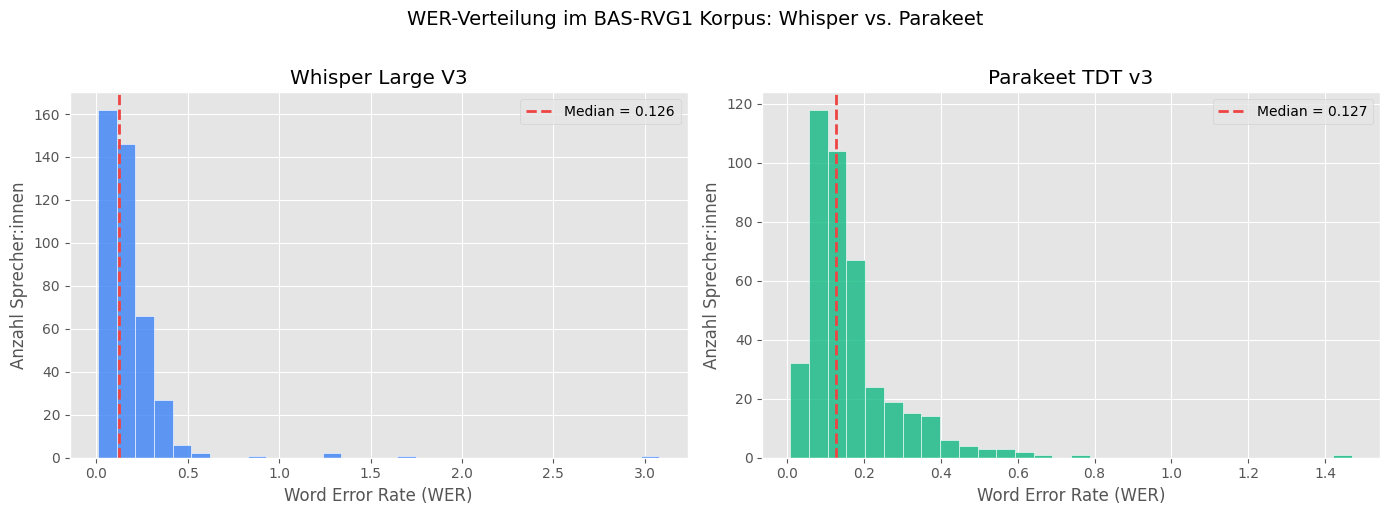

In [8]:
if has_parakeet:
    # Zwei Histogramme nebeneinander für direkten Vergleich
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Whisper Large V3
    whisper_wer = df["whisper_large_v3_wer"].dropna()
    axes[0].hist(whisper_wer, bins=30, color="#3B82F6", edgecolor="white", alpha=0.8)
    whisper_median = whisper_wer.median()
    axes[0].axvline(whisper_median, color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {whisper_median:.3f}")
    axes[0].set_xlabel("Word Error Rate (WER)")
    axes[0].set_ylabel("Anzahl Sprecher:innen")
    axes[0].set_title("Whisper Large V3")
    axes[0].legend()
    
    # Parakeet TDT v3
    parakeet_wer = df["parakeet_tdt_v3_wer"].dropna()
    axes[1].hist(parakeet_wer, bins=30, color="#10B981", edgecolor="white", alpha=0.8)
    parakeet_median = parakeet_wer.median()
    axes[1].axvline(parakeet_median, color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {parakeet_median:.3f}")
    axes[1].set_xlabel("Word Error Rate (WER)")
    axes[1].set_ylabel("Anzahl Sprecher:innen")
    axes[1].set_title("Parakeet TDT v3")
    axes[1].legend()
    
    fig.suptitle("WER-Verteilung im BAS-RVG1 Korpus: Whisper vs. Parakeet", fontsize=14, y=1.02)
    plt.tight_layout()
else:
    # Nur Whisper verfügbar (Fallback)
    fig, ax = plt.subplots(figsize=(10, 4))
    wer_values = df["whisper_large_v3_wer"].dropna()
    ax.hist(wer_values, bins=30, color="#3B82F6", edgecolor="white")
    median_wer = wer_values.median()
    ax.axvline(median_wer, color="#EF4444", linestyle="--", label=f"Median = {median_wer:.3f}")
    ax.set_xlabel("Word Error Rate (WER)")
    ax.set_ylabel("Anzahl Sprecher:innen")
    ax.set_title("Verteilung der Whisper-Large-V3 WER im BAS-RVG1 Korpus")
    ax.legend()
    plt.tight_layout()

Verglichene Sprecher:innen: 414


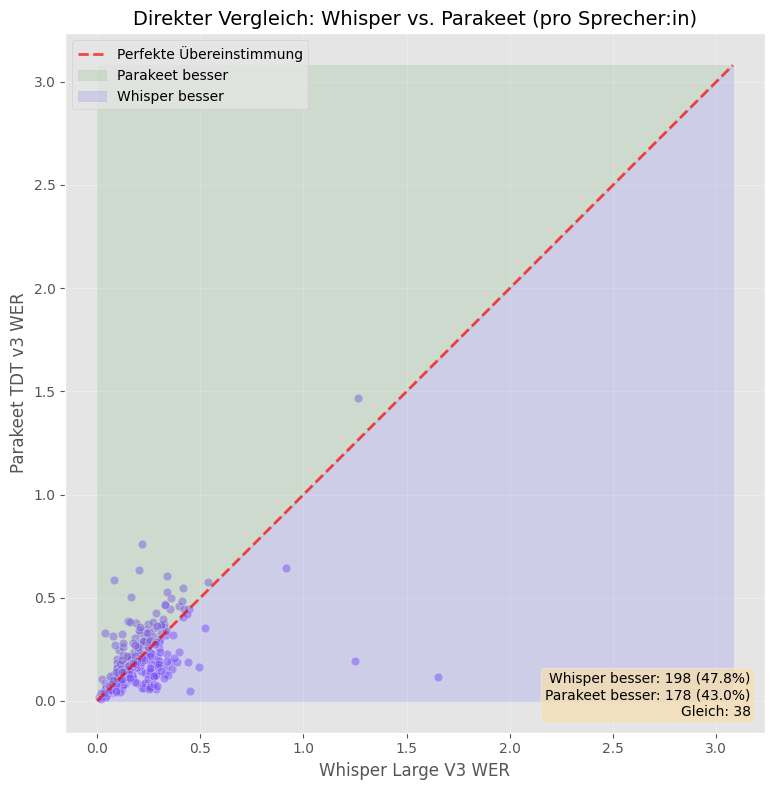

In [9]:
if has_parakeet:
    # Direkter Vergleich: Scatter-Plot Whisper vs. Parakeet
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Nur gültige Paare (beide Werte vorhanden)
    comparison_df = df[["whisper_large_v3_wer", "parakeet_tdt_v3_wer"]].dropna()
    
    ax.scatter(comparison_df["whisper_large_v3_wer"], 
               comparison_df["parakeet_tdt_v3_wer"], 
               alpha=0.5, s=40, color="#8B5CF6", edgecolors="white", linewidth=0.5)
    
    # Diagonale: Perfekte Übereinstimmung
    max_val = max(comparison_df["whisper_large_v3_wer"].max(), comparison_df["parakeet_tdt_v3_wer"].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.7, label="Perfekte Übereinstimmung")
    
    # Bereiche markieren
    ax.fill_between([0, max_val], [0, max_val], max_val, alpha=0.1, color="green", label="Parakeet besser")
    ax.fill_between([0, max_val], 0, [0, max_val], alpha=0.1, color="blue", label="Whisper besser")
    
    ax.set_xlabel("Whisper Large V3 WER", fontsize=12)
    ax.set_ylabel("Parakeet TDT v3 WER", fontsize=12)
    ax.set_title("Direkter Vergleich: Whisper vs. Parakeet (pro Sprecher:in)", fontsize=14)
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    # Statistik anzeigen
    whisper_better = (comparison_df["whisper_large_v3_wer"] < comparison_df["parakeet_tdt_v3_wer"]).sum()
    parakeet_better = (comparison_df["parakeet_tdt_v3_wer"] < comparison_df["whisper_large_v3_wer"]).sum()
    tied = (comparison_df["whisper_large_v3_wer"] == comparison_df["parakeet_tdt_v3_wer"]).sum()
    
    stats_text = f"Whisper besser: {whisper_better} ({whisper_better/len(comparison_df)*100:.1f}%)\n"
    stats_text += f"Parakeet besser: {parakeet_better} ({parakeet_better/len(comparison_df)*100:.1f}%)\n"
    stats_text += f"Gleich: {tied}"
    
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    print(f"Verglichene Sprecher:innen: {len(comparison_df)}")

In [10]:
DIALECT_FALLBACK = "Unbekannt"

def normalize_dialect(value: str) -> str:
    """Leitet eine kompakte Dialektgruppe aus `dialect_self` ab."""
    if not isinstance(value, str):
        return DIALECT_FALLBACK
    cleaned = re.sub(r"\(.*?\)", "", value)
    primary = re.split(r"[\\/.,;]", cleaned)[0]
    primary = re.sub(r"[^0-9A-Za-zÄÖÜäöüß]+", " ", primary)
    primary = primary.strip()
    if not primary:
        return DIALECT_FALLBACK
    normalized = primary.lower()
    normalized = normalized.replace("ae", "ä").replace("oe", "ö").replace("ue", "ü")
    return normalized.title()

df["dialect_group"] = df["dialect_self"].apply(normalize_dialect)
df[["dialect_self", "dialect_group"]].head(10)


,dialect_self,dialect_group
0,hochdeutsch/süd,Hochdeutsch
1,hochdeutsch/süd,Hochdeutsch
2,mittelbairisch,Mittelbairisch
3,schwäbisch,Schwäbisch
4,salzburgerisch,Salzburgerisch
5,bairisch,Bairisch
6,hochdeutsch/süd,Hochdeutsch
7,nordbairisch,Nordbairisch
8,bairisch,Bairisch
9,bairisch,Bairisch


In [11]:
min_samples = 5

if has_parakeet:
    # Metriken für beide Modelle aggregieren
    metrics = (
        df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"])
          .groupby("dialect_group")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              whisper_mean=("whisper_large_v3_wer", "mean"),
              whisper_median=("whisper_large_v3_wer", "median"),
              whisper_std=("whisper_large_v3_wer", "std"),
              parakeet_mean=("parakeet_tdt_v3_wer", "mean"),
              parakeet_median=("parakeet_tdt_v3_wer", "median"),
              parakeet_std=("parakeet_tdt_v3_wer", "std"),
          )
    )
    
    # Differenz berechnen (positiv = Parakeet schlechter, negativ = Parakeet besser)
    metrics["wer_diff"] = metrics["parakeet_mean"] - metrics["whisper_mean"]
    metrics["avg_wer"] = (metrics["whisper_mean"] + metrics["parakeet_mean"]) / 2
    
    dialect_overview = (
        metrics.loc[metrics["samples"] >= min_samples]
        .sort_values("avg_wer")
        .round({"whisper_mean": 3, "whisper_median": 3, "whisper_std": 3,
                "parakeet_mean": 3, "parakeet_median": 3, "parakeet_std": 3,
                "wer_diff": 3, "avg_wer": 3})
    )
    
    print(f"Dialektgruppen mit mindestens {min_samples} Sprecher:innen: {len(dialect_overview)}")
    print(f"Durchschnittliche WER-Differenz (Parakeet - Whisper): {metrics['wer_diff'].mean():.3f}")
    dialect_overview
else:
    # Nur Whisper (Fallback)
    metrics = (
        df.dropna(subset=["whisper_large_v3_wer"])
          .groupby("dialect_group")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              mean_wer=("whisper_large_v3_wer", "mean"),
              median_wer=("whisper_large_v3_wer", "median"),
              std_wer=("whisper_large_v3_wer", "std"),
              wer_p25=("whisper_large_v3_wer", lambda s: s.quantile(0.25)),
              wer_p75=("whisper_large_v3_wer", lambda s: s.quantile(0.75)),
          )
    )
    
    dialect_overview = (
        metrics.loc[metrics["samples"] >= min_samples]
        .sort_values("mean_wer")
        .round({"mean_wer": 3, "median_wer": 3, "std_wer": 3, "wer_p25": 3, "wer_p75": 3})
    )
    
    print(f"Dialektgruppen mit mindestens {min_sPleamples} Sprecher:innen: {len(dialect_overview)}")
    dialect_overview

Dialektgruppen mit mindestens 5 Sprecher:innen: 19
Durchschnittliche WER-Differenz (Parakeet - Whisper): -0.005


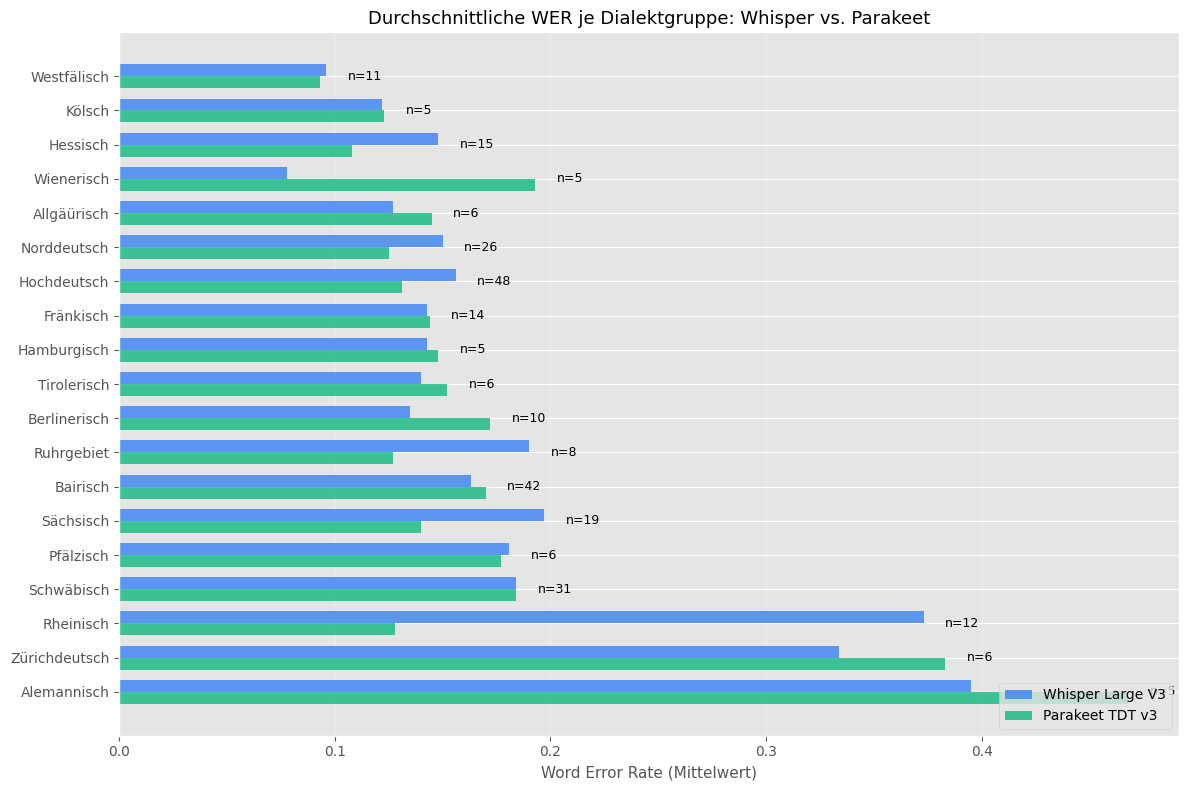

In [12]:
plot_df = dialect_overview
if plot_df.empty:
    print("Keine Dialektgruppen erfüllen die Mindestanzahl für die Visualisierung.")
elif has_parakeet:
    # Grouped Bar Chart für beide Modelle
    fig, ax = plt.subplots(figsize=(12, 8))
    
    dialects = plot_df.index
    x = list(range(len(dialects)))
    width = 0.35
    
    # Balken für beide Modelle
    whisper_bars = ax.barh([i - width/2 for i in x], plot_df["whisper_mean"], 
                            height=width, color="#3B82F6", alpha=0.8, label="Whisper Large V3")
    parakeet_bars = ax.barh([i + width/2 for i in x], plot_df["parakeet_mean"], 
                             height=width, color="#10B981", alpha=0.8, label="Parakeet TDT v3")
    
    # Sample-Zahlen anzeigen
    for i, (w_mean, p_mean, samples) in enumerate(zip(plot_df["whisper_mean"], 
                                                        plot_df["parakeet_mean"], 
                                                        plot_df["samples"])):
        max_val = max(w_mean, p_mean)
        ax.text(max_val + 0.01, i, f"n={samples}", va="center", fontsize=9)
    
    ax.set_yticks(x)
    ax.set_yticklabels(dialects)
    ax.set_xlabel("Word Error Rate (Mittelwert)", fontsize=11)
    ax.set_title("Durchschnittliche WER je Dialektgruppe: Whisper vs. Parakeet", fontsize=13)
    ax.invert_yaxis()
    ax.legend(loc="lower right")
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
else:
    # Nur Whisper (Fallback)
    fig, ax = plt.subplots(figsize=(10, 6))
    y_positions = list(range(len(plot_df)))
    ax.barh(y_positions, plot_df["mean_wer"], color="#2563EB", alpha=0.8, label="Mittelwert")
    for idx, (lower, upper) in enumerate(zip(plot_df["wer_p25"], plot_df["wer_p75"])):
        ax.hlines(idx, lower, upper, color="#F97316", linewidth=4, label="IQR" if idx == 0 else "")
    for idx, (mean, samples) in enumerate(zip(plot_df["mean_wer"], plot_df["samples"])):
        ax.text(mean + 0.005, idx, f"n={samples}", va="center", fontsize=9)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(plot_df.index)
    ax.set_xlabel("Word Error Rate")
    ax.set_title("Durchschnittliche WER je Dialektgruppe (IQR als Linie)")
    ax.invert_yaxis()
    ax.legend(loc="lower right")
    plt.tight_layout()

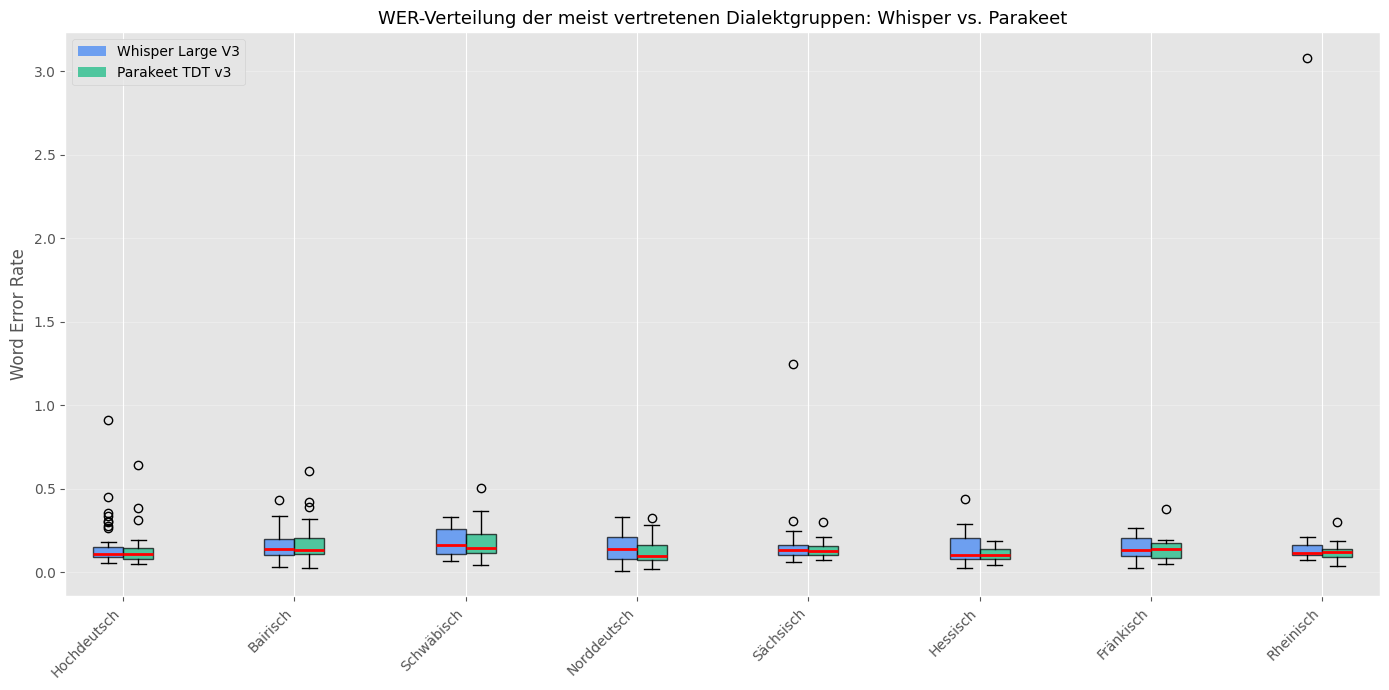

In [13]:
top_groups = metrics.sort_values("samples", ascending=False).head(8).index
subset = df[df["dialect_group"].isin(top_groups)].copy()

if subset.empty:
    print("Keine ausreichenden Daten für die Boxplot-Visualisierung.")
elif has_parakeet:
    # Boxplots für beide Modelle nebeneinander
    subset["dialect_group"] = pd.Categorical(subset["dialect_group"], categories=top_groups, ordered=True)
    
    # Daten für Boxplot vorbereiten (long format)
    whisper_data = subset[["dialect_group", "whisper_large_v3_wer"]].copy()
    whisper_data["model"] = "Whisper Large V3"
    whisper_data = whisper_data.rename(columns={"whisper_large_v3_wer": "wer"})
    
    parakeet_data = subset[["dialect_group", "parakeet_tdt_v3_wer"]].copy()
    parakeet_data["model"] = "Parakeet TDT v3"
    parakeet_data = parakeet_data.rename(columns={"parakeet_tdt_v3_wer": "wer"})
    
    combined = pd.concat([whisper_data, parakeet_data], ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Manueller grouped boxplot
    positions = []
    whisper_positions = []
    parakeet_positions = []
    group_width = 0.8
    box_width = 0.35
    
    for i, group in enumerate(top_groups):
        whisper_positions.append(i * 2 - box_width/2)
        parakeet_positions.append(i * 2 + box_width/2)
    
    # Whisper Boxplots
    whisper_boxdata = [subset[subset["dialect_group"] == g]["whisper_large_v3_wer"].dropna().values 
                       for g in top_groups]
    bp1 = ax.boxplot(whisper_boxdata, positions=whisper_positions, widths=box_width,
                     patch_artist=True, boxprops=dict(facecolor="#3B82F6", alpha=0.7),
                     medianprops=dict(color="red", linewidth=2))
    
    # Parakeet Boxplots
    parakeet_boxdata = [subset[subset["dialect_group"] == g]["parakeet_tdt_v3_wer"].dropna().values 
                        for g in top_groups]
    bp2 = ax.boxplot(parakeet_boxdata, positions=parakeet_positions, widths=box_width,
                     patch_artist=True, boxprops=dict(facecolor="#10B981", alpha=0.7),
                     medianprops=dict(color="red", linewidth=2))
    
    # X-Achse konfigurieren
    ax.set_xticks([i * 2 for i in range(len(top_groups))])
    ax.set_xticklabels(top_groups, rotation=45, ha="right")
    ax.set_ylabel("Word Error Rate")
    ax.set_title("WER-Verteilung der meist vertretenen Dialektgruppen: Whisper vs. Parakeet", fontsize=13)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3B82F6', alpha=0.7, label='Whisper Large V3'),
                      Patch(facecolor='#10B981', alpha=0.7, label='Parakeet TDT v3')]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
else:
    # Nur Whisper (Fallback)
    subset["dialect_group"] = pd.Categorical(subset["dialect_group"], categories=top_groups, ordered=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    subset.boxplot(column="whisper_large_v3_wer", by="dialect_group", ax=ax, grid=False)
    ax.set_ylabel("Word Error Rate")
    ax.set_xlabel("Dialektgruppe")
    ax.set_title("WER-Verteilung der meist vertretenen Dialektgruppen")
    plt.suptitle("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

MODELL-PERFORMANCE PRO DIALEKTGRUPPE

Whisper gewinnt bei: 10 Dialekten
Parakeet gewinnt bei: 8 Dialekten
Unentschieden: 1 Dialekte

Durchschnittliche absolute Differenz: 0.041

Top 10 größte Unterschiede:
               whisper_mean  parakeet_mean  wer_diff    winner
dialect_group                                                 
Rheinisch             0.373          0.128    -0.245  Parakeet
Wienerisch            0.078          0.193     0.115   Whisper
Alemannisch           0.395          0.468     0.073   Whisper
Ruhrgebiet            0.190          0.127    -0.063  Parakeet
Sächsisch             0.197          0.140    -0.057  Parakeet
Zürichdeutsch         0.334          0.383     0.049   Whisper
Hessisch              0.148          0.108    -0.040  Parakeet
Berlinerisch          0.135          0.172     0.038   Whisper
Norddeutsch           0.150          0.125    -0.025  Parakeet
Hochdeutsch           0.156          0.131    -0.025  Parakeet


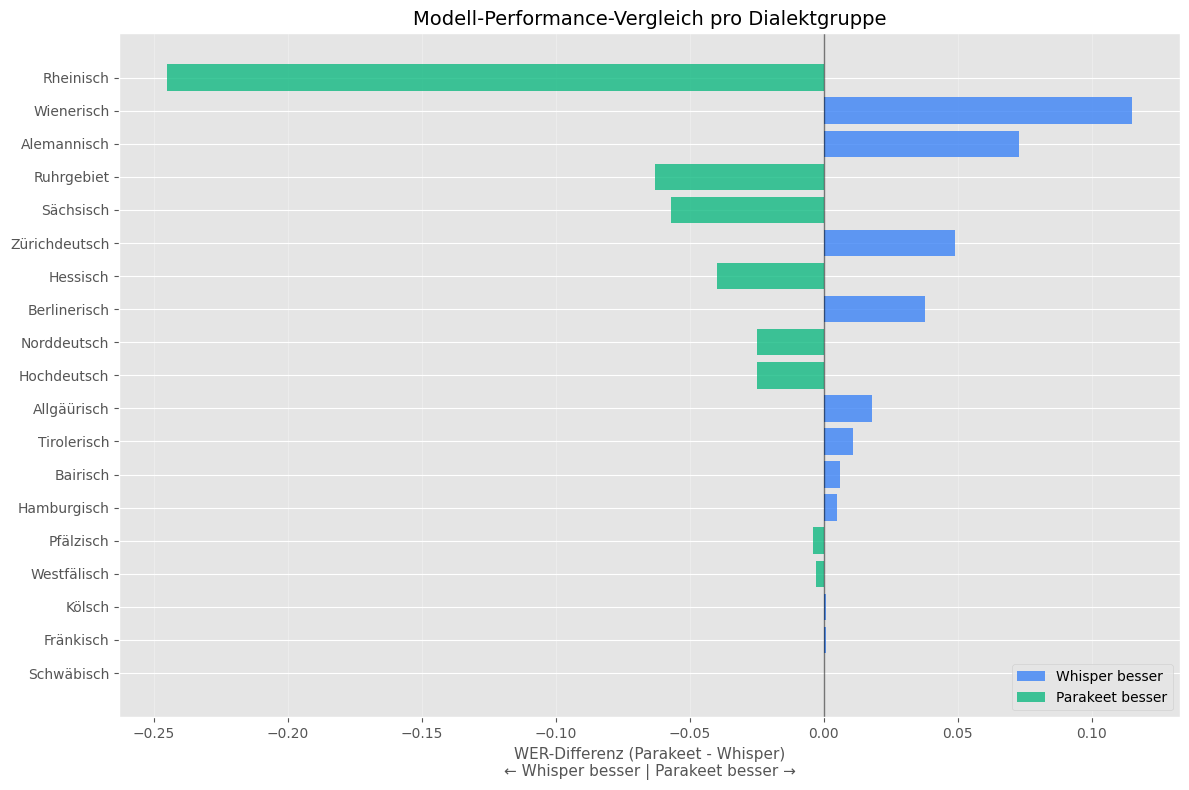

In [14]:
if has_parakeet:
    # Performance-Gewinner-Analyse: Welches Modell ist bei welchem Dialekt besser?
    winner_df = dialect_overview[["samples", "whisper_mean", "parakeet_mean", "wer_diff"]].copy()
    winner_df["winner"] = winner_df["wer_diff"].apply(
        lambda x: "Whisper" if x > 0 else ("Parakeet" if x < 0 else "Gleich")
    )
    winner_df["abs_diff"] = winner_df["wer_diff"].abs()
    
    # Nach größter absoluter Differenz sortieren
    winner_df_sorted = winner_df.sort_values("abs_diff", ascending=False)
    
    print("=" * 80)
    print("MODELL-PERFORMANCE PRO DIALEKTGRUPPE")
    print("=" * 80)
    print(f"\nWhisper gewinnt bei: {(winner_df['winner'] == 'Whisper').sum()} Dialekten")
    print(f"Parakeet gewinnt bei: {(winner_df['winner'] == 'Parakeet').sum()} Dialekten")
    print(f"Unentschieden: {(winner_df['winner'] == 'Gleich').sum()} Dialekte")
    print(f"\nDurchschnittliche absolute Differenz: {winner_df['abs_diff'].mean():.3f}")
    print("\nTop 10 größte Unterschiede:")
    print(winner_df_sorted[["whisper_mean", "parakeet_mean", "wer_diff", "winner"]].head(10))
    
    # Visualisierung: WER-Differenz pro Dialekt
    fig, ax = plt.subplots(figsize=(12, 8))
    
    dialects = winner_df_sorted.index
    diffs = winner_df_sorted["wer_diff"]
    colors = ["#3B82F6" if d > 0 else "#10B981" for d in diffs]
    
    y_pos = list(range(len(dialects)))
    ax.barh(y_pos, diffs, color=colors, alpha=0.8)
    
    # Null-Linie
    ax.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    
    # Beschriftungen
    ax.set_yticks(y_pos)
    ax.set_yticklabels(dialects)
    ax.set_xlabel("WER-Differenz (Parakeet - Whisper)\n← Whisper besser | Parakeet besser →", fontsize=11)
    ax.set_title("Modell-Performance-Vergleich pro Dialektgruppe", fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3B82F6', alpha=0.8, label='Whisper besser'),
        Patch(facecolor='#10B981', alpha=0.8, label='Parakeet besser')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    winner_df_sorted

## LLM-basierte Hochdeutsch-Referenz Evaluation

**Optional:** Falls die CSV-Datei mit `enrich_csvs.py` erweitert wurde, enthält sie zusätzlich:
- `hochdeutsch_translation`: LLM-generierte Hochdeutsch-Übersetzung der dialektischen Ground-Truth
- `whisper_wer_hochdeutsch`: WER von Whisper Large V3 gegen Hochdeutsch-Referenz
- `parakeet_wer_hochdeutsch`: WER von Parakeet TDT v3 gegen Hochdeutsch-Referenz

Diese Sektion vergleicht die WER-Werte bei Verwendung der **dialektischen Ground-Truth** vs. der **Hochdeutsch-Referenz** und analysiert, ob bestimmte Dialektgruppen von einer Hochdeutsch-Normalisierung profitieren.

In [15]:
if has_hochdeutsch and has_parakeet:
    # Vergleichende Statistiken: dialektisches WER vs. Hochdeutsch-WER
    comparison_hd = pd.DataFrame({
        "Whisper (dialektisch)": df["whisper_large_v3_wer"].describe(percentiles=[0.25, 0.5, 0.75]),
        "Whisper (Hochdeutsch)": df["whisper_wer_hochdeutsch"].describe(percentiles=[0.25, 0.5, 0.75]),
        "Parakeet (dialektisch)": df["parakeet_tdt_v3_wer"].describe(percentiles=[0.25, 0.5, 0.75]),
        "Parakeet (Hochdeutsch)": df["parakeet_wer_hochdeutsch"].describe(percentiles=[0.25, 0.5, 0.75]),
    })
    
    # Durchschnittliche Änderung berechnen
    whisper_diff = (df["whisper_wer_hochdeutsch"] - df["whisper_large_v3_wer"]).mean()
    parakeet_diff = (df["parakeet_wer_hochdeutsch"] - df["parakeet_tdt_v3_wer"]).mean()
    
    print(f"Durchschnittliche WER-Änderung durch Hochdeutsch-Referenz:")
    print(f"  Whisper:  {whisper_diff:+.4f} ({'Verschlechterung' if whisper_diff > 0 else 'Verbesserung'})")
    print(f"  Parakeet: {parakeet_diff:+.4f} ({'Verschlechterung' if parakeet_diff > 0 else 'Verbesserung'})")
    print()
    
    comparison_hd.round(4)
elif has_hochdeutsch:
    print("⚠ Parakeet-Spalten fehlen, nur Whisper-Vergleich verfügbar")
else:
    print("⚠ Keine Hochdeutsch-Spalten verfügbar. Überspringe Analyse.")

Durchschnittliche WER-Änderung durch Hochdeutsch-Referenz:
  Whisper:  +0.3254 (Verschlechterung)
  Parakeet: +0.3140 (Verschlechterung)



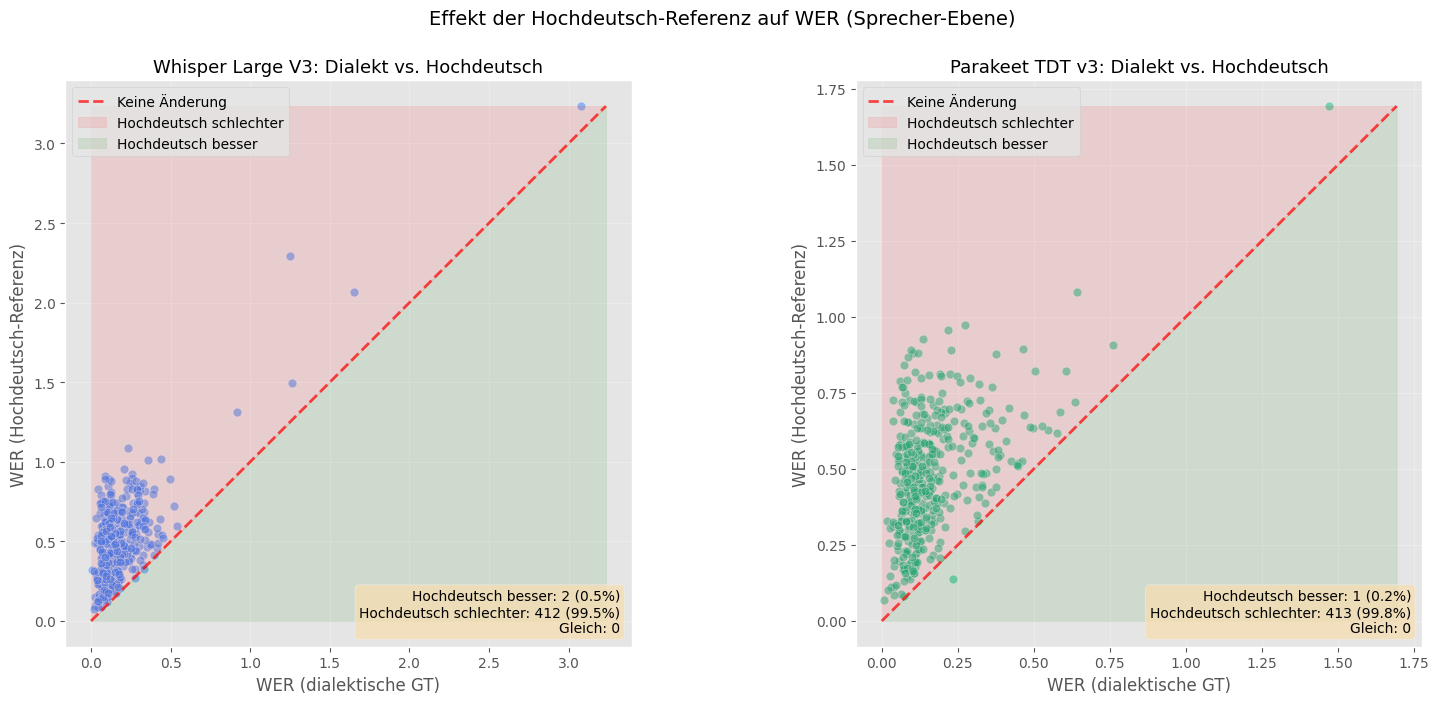

In [16]:
if has_hochdeutsch and has_parakeet:
    # Scatter-Plots: dialektisches WER vs. Hochdeutsch-WER für beide Modelle
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Whisper: dialektisch vs. Hochdeutsch
    whisper_comp = df[["whisper_large_v3_wer", "whisper_wer_hochdeutsch"]].dropna()
    ax1 = axes[0]
    ax1.scatter(whisper_comp["whisper_large_v3_wer"], 
                whisper_comp["whisper_wer_hochdeutsch"],
                alpha=0.5, s=40, color="#3B82F6", edgecolors="white", linewidth=0.5)
    
    # Diagonale
    max_w = max(whisper_comp["whisper_large_v3_wer"].max(), whisper_comp["whisper_wer_hochdeutsch"].max())
    ax1.plot([0, max_w], [0, max_w], 'r--', linewidth=2, alpha=0.7, label="Keine Änderung")
    ax1.fill_between([0, max_w], [0, max_w], max_w, alpha=0.1, color="red", label="Hochdeutsch schlechter")
    ax1.fill_between([0, max_w], 0, [0, max_w], alpha=0.1, color="green", label="Hochdeutsch besser")
    
    ax1.set_xlabel("WER (dialektische GT)", fontsize=12)
    ax1.set_ylabel("WER (Hochdeutsch-Referenz)", fontsize=12)
    ax1.set_title("Whisper Large V3: Dialekt vs. Hochdeutsch", fontsize=13)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='box')
    
    # Statistik
    w_better = (whisper_comp["whisper_wer_hochdeutsch"] < whisper_comp["whisper_large_v3_wer"]).sum()
    w_worse = (whisper_comp["whisper_wer_hochdeutsch"] > whisper_comp["whisper_large_v3_wer"]).sum()
    w_same = (whisper_comp["whisper_wer_hochdeutsch"] == whisper_comp["whisper_large_v3_wer"]).sum()
    
    stats_w = f"Hochdeutsch besser: {w_better} ({w_better/len(whisper_comp)*100:.1f}%)\n"
    stats_w += f"Hochdeutsch schlechter: {w_worse} ({w_worse/len(whisper_comp)*100:.1f}%)\n"
    stats_w += f"Gleich: {w_same}"
    ax1.text(0.98, 0.02, stats_w, transform=ax1.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Parakeet: dialektisch vs. Hochdeutsch
    parakeet_comp = df[["parakeet_tdt_v3_wer", "parakeet_wer_hochdeutsch"]].dropna()
    ax2 = axes[1]
    ax2.scatter(parakeet_comp["parakeet_tdt_v3_wer"],
                parakeet_comp["parakeet_wer_hochdeutsch"],
                alpha=0.5, s=40, color="#10B981", edgecolors="white", linewidth=0.5)
    
    # Diagonale
    max_p = max(parakeet_comp["parakeet_tdt_v3_wer"].max(), parakeet_comp["parakeet_wer_hochdeutsch"].max())
    ax2.plot([0, max_p], [0, max_p], 'r--', linewidth=2, alpha=0.7, label="Keine Änderung")
    ax2.fill_between([0, max_p], [0, max_p], max_p, alpha=0.1, color="red", label="Hochdeutsch schlechter")
    ax2.fill_between([0, max_p], 0, [0, max_p], alpha=0.1, color="green", label="Hochdeutsch besser")
    
    ax2.set_xlabel("WER (dialektische GT)", fontsize=12)
    ax2.set_ylabel("WER (Hochdeutsch-Referenz)", fontsize=12)
    ax2.set_title("Parakeet TDT v3: Dialekt vs. Hochdeutsch", fontsize=13)
    ax2.legend(loc="upper left")
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
    
    # Statistik
    p_better = (parakeet_comp["parakeet_wer_hochdeutsch"] < parakeet_comp["parakeet_tdt_v3_wer"]).sum()
    p_worse = (parakeet_comp["parakeet_wer_hochdeutsch"] > parakeet_comp["parakeet_tdt_v3_wer"]).sum()
    p_same = (parakeet_comp["parakeet_wer_hochdeutsch"] == parakeet_comp["parakeet_tdt_v3_wer"]).sum()
    
    stats_p = f"Hochdeutsch besser: {p_better} ({p_better/len(parakeet_comp)*100:.1f}%)\n"
    stats_p += f"Hochdeutsch schlechter: {p_worse} ({p_worse/len(parakeet_comp)*100:.1f}%)\n"
    stats_p += f"Gleich: {p_same}"
    ax2.text(0.98, 0.02, stats_p, transform=ax2.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    fig.suptitle("Effekt der Hochdeutsch-Referenz auf WER (Sprecher-Ebene)", fontsize=14, y=1.00)
    plt.tight_layout()
elif has_hochdeutsch:
    print("⚠ Parakeet-Spalten fehlen, Visualisierung übersprungen")
else:
    print("⚠ Keine Hochdeutsch-Spalten verfügbar.")

In [17]:
if has_hochdeutsch and has_parakeet:
    # Dialektgruppen-Analyse: Durchschnittliche WER-Änderung pro Dialekt
    min_samples_hd = 5
    
    # WER-Differenzen berechnen (Hochdeutsch - dialektisch)
    df["whisper_wer_diff"] = df["whisper_wer_hochdeutsch"] - df["whisper_large_v3_wer"]
    df["parakeet_wer_diff"] = df["parakeet_wer_hochdeutsch"] - df["parakeet_tdt_v3_wer"]
    
    # Pro Dialektgruppe aggregieren
    hd_metrics = (
        df.dropna(subset=["whisper_wer_diff", "parakeet_wer_diff"])
          .groupby("dialect_group")
          .agg(
              samples=("whisper_wer_diff", "count"),
              whisper_diff_mean=("whisper_wer_diff", "mean"),
              whisper_diff_std=("whisper_wer_diff", "std"),
              parakeet_diff_mean=("parakeet_wer_diff", "mean"),
              parakeet_diff_std=("parakeet_wer_diff", "std"),
          )
    )
    
    # Durchschnittliche Differenz über beide Modelle
    hd_metrics["avg_diff"] = (hd_metrics["whisper_diff_mean"] + hd_metrics["parakeet_diff_mean"]) / 2
    
    # Filtern nach Mindestanzahl
    hd_dialect_overview = (
        hd_metrics.loc[hd_metrics["samples"] >= min_samples_hd]
        .sort_values("avg_diff")
        .round({"whisper_diff_mean": 4, "whisper_diff_std": 4,
                "parakeet_diff_mean": 4, "parakeet_diff_std": 4,
                "avg_diff": 4})
    )
    
    print(f"Dialektgruppen mit mindestens {min_samples_hd} Sprecher:innen: {len(hd_dialect_overview)}")
    print(f"\nDialekte mit größter Verbesserung durch Hochdeutsch-Referenz:")
    print(hd_dialect_overview.nsmallest(5, "avg_diff")[["samples", "whisper_diff_mean", "parakeet_diff_mean", "avg_diff"]])
    print(f"\nDialekte mit größter Verschlechterung durch Hochdeutsch-Referenz:")
    print(hd_dialect_overview.nlargest(5, "avg_diff")[["samples", "whisper_diff_mean", "parakeet_diff_mean", "avg_diff"]])
    print()
    
    hd_dialect_overview
elif has_hochdeutsch:
    print("⚠ Parakeet-Spalten fehlen, Dialektgruppen-Analyse übersprungen")
else:
    print("⚠ Keine Hochdeutsch-Spalten verfügbar.")

Dialektgruppen mit mindestens 5 Sprecher:innen: 19

Dialekte mit größter Verbesserung durch Hochdeutsch-Referenz:
               samples  whisper_diff_mean  parakeet_diff_mean  avg_diff
dialect_group                                                          
Zürichdeutsch        6             0.0994              0.1027    0.1010
Wienerisch           5             0.1925              0.1464    0.1694
Kölsch               5             0.2411              0.2279    0.2345
Hessisch            15             0.2882              0.2790    0.2836
Rheinisch           12             0.2957              0.2861    0.2909

Dialekte mit größter Verschlechterung durch Hochdeutsch-Referenz:
               samples  whisper_diff_mean  parakeet_diff_mean  avg_diff
dialect_group                                                          
Hamburgisch          5             0.4137              0.3848    0.3992
Sächsisch           19             0.3952              0.3635    0.3794
Bairisch            42     

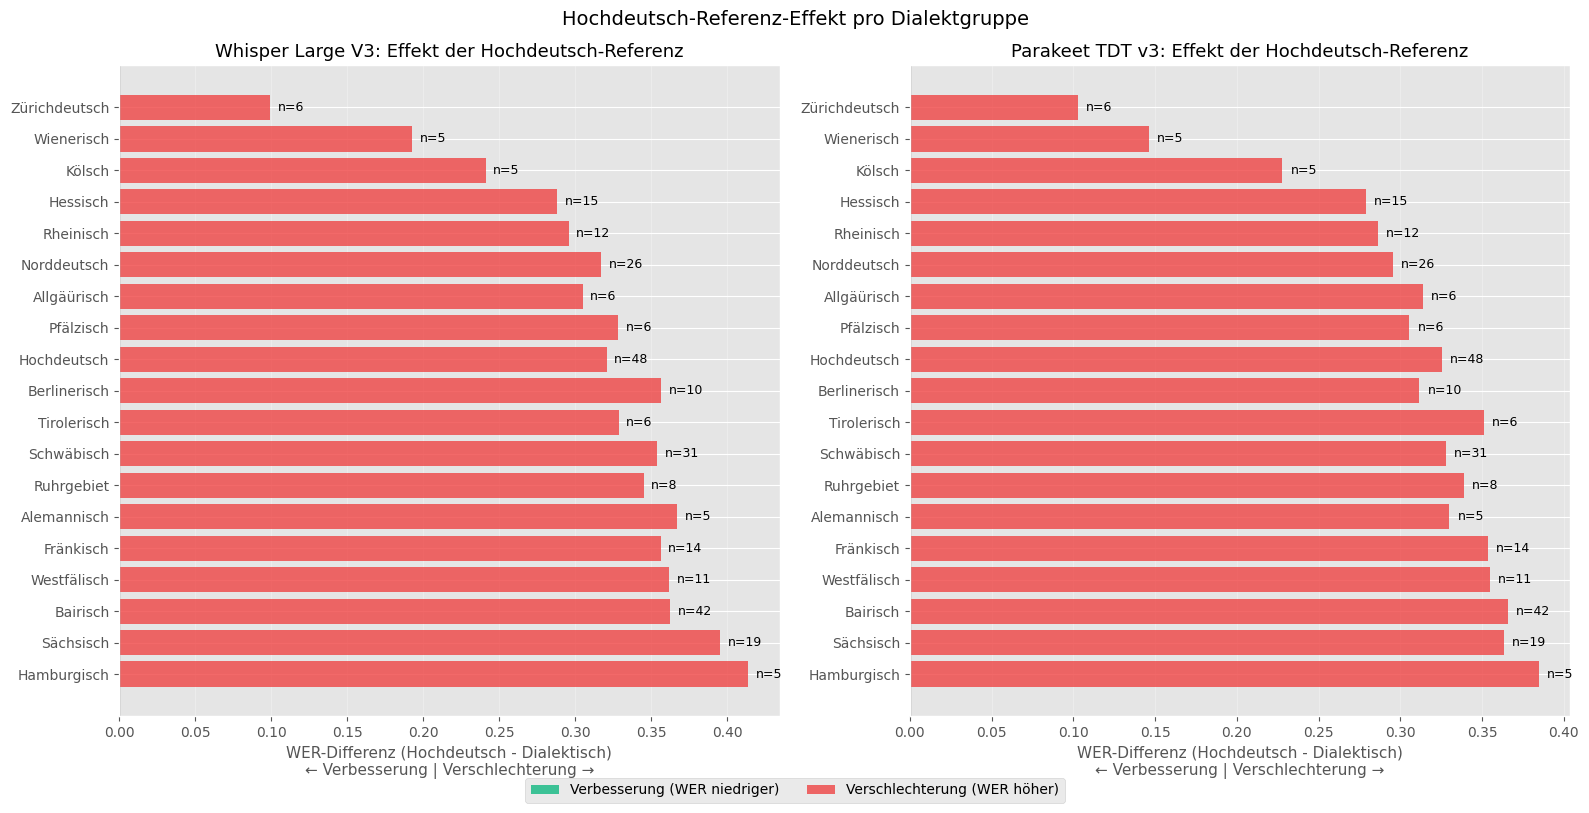

In [18]:
if has_hochdeutsch and has_parakeet and not hd_dialect_overview.empty:
    # Bar-Chart: WER-Differenz pro Dialektgruppe (beide Modelle)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    dialects = hd_dialect_overview.index
    x = list(range(len(dialects)))
    width = 0.35
    
    # Whisper WER-Differenz
    ax1 = axes[0]
    colors_w = ["#10B981" if val < 0 else "#EF4444" for val in hd_dialect_overview["whisper_diff_mean"]]
    bars_w = ax1.barh(x, hd_dialect_overview["whisper_diff_mean"], color=colors_w, alpha=0.8)
    
    # Null-Linie
    ax1.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    
    # Sample-Zahlen anzeigen
    for i, (diff, samples) in enumerate(zip(hd_dialect_overview["whisper_diff_mean"], 
                                              hd_dialect_overview["samples"])):
        x_pos = diff + (0.005 if diff > 0 else -0.005)
        ha = "left" if diff > 0 else "right"
        ax1.text(x_pos, i, f"n={samples}", va="center", ha=ha, fontsize=9)
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(dialects)
    ax1.set_xlabel("WER-Differenz (Hochdeutsch - Dialektisch)\n← Verbesserung | Verschlechterung →", fontsize=11)
    ax1.set_title("Whisper Large V3: Effekt der Hochdeutsch-Referenz", fontsize=13)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Parakeet WER-Differenz
    ax2 = axes[1]
    colors_p = ["#10B981" if val < 0 else "#EF4444" for val in hd_dialect_overview["parakeet_diff_mean"]]
    bars_p = ax2.barh(x, hd_dialect_overview["parakeet_diff_mean"], color=colors_p, alpha=0.8)
    
    # Null-Linie
    ax2.axvline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    
    # Sample-Zahlen anzeigen
    for i, (diff, samples) in enumerate(zip(hd_dialect_overview["parakeet_diff_mean"],
                                              hd_dialect_overview["samples"])):
        x_pos = diff + (0.005 if diff > 0 else -0.005)
        ha = "left" if diff > 0 else "right"
        ax2.text(x_pos, i, f"n={samples}", va="center", ha=ha, fontsize=9)
    
    ax2.set_yticks(x)
    ax2.set_yticklabels(dialects)
    ax2.set_xlabel("WER-Differenz (Hochdeutsch - Dialektisch)\n← Verbesserung | Verschlechterung →", fontsize=11)
    ax2.set_title("Parakeet TDT v3: Effekt der Hochdeutsch-Referenz", fontsize=13)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    # Gemeinsame Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#10B981', alpha=0.8, label='Verbesserung (WER niedriger)'),
        Patch(facecolor='#EF4444', alpha=0.8, label='Verschlechterung (WER höher)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
    
    fig.suptitle("Hochdeutsch-Referenz-Effekt pro Dialektgruppe", fontsize=14, y=0.98)
    plt.tight_layout()
elif has_hochdeutsch and has_parakeet:
    print("⚠ Keine Dialektgruppen mit ausreichend Daten für Visualisierung")
elif has_hochdeutsch:
    print("⚠ Parakeet-Spalten fehlen, Visualisierung übersprungen")
else:
    print("⚠ Keine Hochdeutsch-Spalten verfügbar.")

## Zusammenfassung & Hinweise

**Methodik**
- Die Normalisierung der Dialektangaben reduziert Schreibvarianten (z. B. `/`, Klammern, Umlaute) auf konsistente Gruppen.
- Beide Modelle (Whisper Large V3 und Parakeet TDT v3) werden mit identischen Ground-Truth-Transkriptionen evaluiert.
- WER-Berechnung erfolgt mit denselben Normalisierungsregeln für faire Vergleichbarkeit.

**Interpretationshinweise**
- Einzelne Sprecher:innen mit extrem hohen WER-Werten können Ausreißer darstellen und sollten für fundierte Analysen genauer geprüft werden.
- Die Performance-Unterschiede zwischen den Modellen können dialektspezifisch sein und deuten auf unterschiedliche Trainingsdaten-Schwerpunkte hin.
- Für feinere Analysen lassen sich die Filterparameter (`min_samples`, `top_groups`) im Notebook anpassen.

**Modellvergleich**
- Die Scatter-Plot-Analyse zeigt sprecher-spezifische Performance-Unterschiede zwischen Whisper und Parakeet.
- Die WER-Differenz-Visualisierung identifiziert Dialektgruppen, bei denen ein Modell besonders stark oder schwach abschneidet.
- Durchschnittswerte pro Dialektgruppe berücksichtigen mindestens 5 Sprecher:innen zur statistischen Robustheit.

**LLM-basierte Hochdeutsch-Referenz (optional)**
- Falls die CSV mit `enrich_csvs.py` erweitert wurde, enthält sie zusätzliche WER-Werte basierend auf einer LLM-generierten Hochdeutsch-Referenz.
- Diese Analyse zeigt, ob die Verwendung einer Hochdeutsch-Normalisierung die WER-Werte verbessert oder verschlechtert.
- Die Ergebnisse können dialektspezifisch variieren und geben Aufschluss über die Robustheit der Modelle gegenüber dialektischen Variationen.
- Negative WER-Differenzen (grün) zeigen Verbesserungen durch Hochdeutsch-Referenz, positive (rot) zeigen Verschlechterungen.